In [22]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split,cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore", category=FutureWarning, message=".*use_inf_as_na.*")  

##### Reading the final cleaned dataset

In [226]:
df_new = pd.read_csv('Cleaned_final_data.csv')
df_test = pd.read_csv('Cleaned_final_test_data.csv')
feat = df_test["instance_id"]

##### Planning with Initial model

In [179]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Dropping columns that won't be used in modeling
df_new.drop(columns=['instance_id', 'artist_name', 'track_name', 'track_id', 'energy'], inplace=True)
df_test.drop(columns=['instance_id', 'artist_name', 'track_name', 'track_id', 'energy'], inplace=True)

# Splitting the data into features and target variable
X = df_new.drop('genre', axis=1)
y = df_new['genre']

# Split: Train and Val Split-> 80-20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test = df_test

# Identify categorical and numerical features
categorical_features = ['key', 'mode']
numerical_features = [col for col in X_train.columns if col not in categorical_features]
categorical_features, numerical_features
# Create a column transformer for pre-processing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_train_scaled = pd.DataFrame(preprocessor.fit_transform(X_train), columns=preprocessor.get_feature_names_out())
X_val_scaled = pd.DataFrame(preprocessor.transform(X_val), columns=preprocessor.get_feature_names_out())
X_test_scaled = pd.DataFrame(preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out())

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

X_train_scaled.shape, X_val_scaled.shape, y_train.shape, y_val.shape, X_test_scaled.shape

((40000, 29), (10000, 29), (40000,), (10000,), (12435, 29))

#### Feature Importance - Dimensionality Reduction- RFE

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


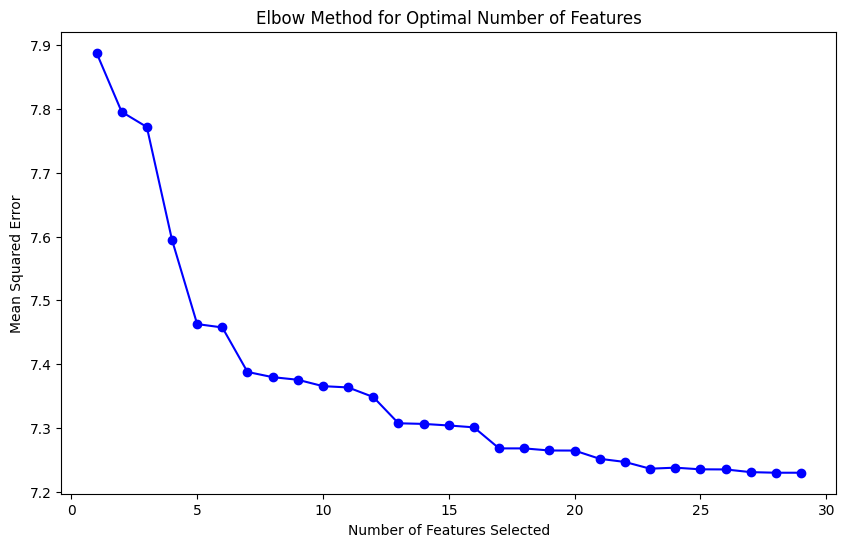

In [184]:
num_features = []
mse_scores = []
# Loop through different numbers of features to select
for n in range(1, X_train_scaled.shape[1] + 1):
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=n)
    rfe.fit(X_train_scaled, y_train)
    
    # Predict on the test set
    y_pred = rfe.predict(X_val_scaled)
    
    # Calculate the MSE
    mse = mean_squared_error(y_val, y_pred)
    
    # Store the results
    num_features.append(n)
    mse_scores.append(mse)
    print(n)

# Plot the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(num_features, mse_scores, 'bo-')
plt.xlabel('Number of Features Selected')
plt.ylabel('Mean Squared Error')
plt.title('Elbow Method for Optimal Number of Features')
plt.show()

##### Initial Model

In [185]:
rf = RandomForestClassifier(random_state=42)

# Initialized RFE with linear regression model and top 6 features to select
rfe = RFE(rf, n_features_to_select=15)

# Fit RFE
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_val_rfe = rfe.transform(X_val_scaled)
X_test_rfe = rfe.transform(X_test_scaled)


# Selected Features
selected_columns = X_train_scaled.columns[rfe.support_]
selected_columns


Index(['num__popularity', 'num__danceability', 'num__duration_ms',
       'num__tempo', 'num__valence', 'num__instrumentalness_mode',
       'num__instrumentalness_low', 'num__instrumentalness_high',
       'num__acousticness_mode', 'num__acousticness_low',
       'num__acousticness_high', 'num__bc_liveness', 'num__bc_loudness',
       'num__bc_speechiness', 'cat__mode_Major'],
      dtype='object')

##### Grid Search

In [188]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
}

# Setup GridSearchCV to tune the hyperparameters using the validation set
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy', verbose=2)
grid_search.fit(X_train_rfe, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Hyperparameters: {'max_depth': 20, 'n_estimators': 300}


In [189]:
best_rf_model = grid_search.best_estimator_

best_rf_model.fit(X_train_rfe, y_train)
# Test Accuracy (final evaluation)
y_val_pred_rf_rfe = best_rf_model.predict(X_val_rfe)
test_accuracy = accuracy_score(y_val, y_val_pred_rf_rfe)
print(f'Test Accuracy with Tuned Model: {test_accuracy:.4f}')

Test Accuracy with Tuned Model: 0.6941


In [190]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

gbc_model = GradientBoostingClassifier(random_state=42)
gbc_model.fit(X_train_rfe, y_train)

GradientBoostingClassifier(random_state=42)

In [191]:
y_val_pred_gbc = gbc_model.predict(X_val_rfe)
test_accuracy = accuracy_score(y_val, y_val_pred_gbc)
print(f'Test Accuracy with Tuned Model: {test_accuracy:.4f}')

Test Accuracy with Tuned Model: 0.7604


In [192]:
import catboost as cb 
cbc = cb.CatBoostClassifier(eval_metric='Accuracy', iterations = 1000) 
cbc.fit(X_train_rfe, y_train, eval_set = (X_val_rfe, y_val))
y_pred = cbc.predict(X_val_rfe)
acc_logreg = round(accuracy_score(y_pred, y_val) * 100, 2)
acc_logreg

Learning rate set to 0.116244
0:	learn: 0.5098250	test: 0.5154000	best: 0.5154000 (0)	total: 50ms	remaining: 49.9s
1:	learn: 0.5175250	test: 0.5217000	best: 0.5217000 (1)	total: 80.7ms	remaining: 40.3s
2:	learn: 0.5622250	test: 0.5643000	best: 0.5643000 (2)	total: 112ms	remaining: 37.3s
3:	learn: 0.5695250	test: 0.5712000	best: 0.5712000 (3)	total: 143ms	remaining: 35.7s
4:	learn: 0.5827750	test: 0.5865000	best: 0.5865000 (4)	total: 174ms	remaining: 34.7s
5:	learn: 0.5918000	test: 0.5953000	best: 0.5953000 (5)	total: 214ms	remaining: 35.5s
6:	learn: 0.5952250	test: 0.5980000	best: 0.5980000 (6)	total: 257ms	remaining: 36.4s
7:	learn: 0.5969250	test: 0.6034000	best: 0.6034000 (7)	total: 292ms	remaining: 36.2s
8:	learn: 0.6000750	test: 0.6040000	best: 0.6040000 (8)	total: 323ms	remaining: 35.6s
9:	learn: 0.6025000	test: 0.6072000	best: 0.6072000 (9)	total: 355ms	remaining: 35.1s
10:	learn: 0.6048000	test: 0.6092000	best: 0.6092000 (10)	total: 383ms	remaining: 34.5s
11:	learn: 0.6082750	t

76.89

In [198]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.datasets import make_hastie_10_2

clf = HistGradientBoostingClassifier(max_iter=1000, random_state=42).fit(X_train_rfe, y_train)
predictions = clf.predict(X_val_rfe)

# Accuracy of the model
acc = accuracy_score(predictions, y_val)
acc

0.7574

In [199]:
from sklearn.ensemble import VotingClassifier

# Ensemble with Voting Classifier
voting_model = VotingClassifier(estimators=[
    ('cbc', cbc),
    ('gbc', gbc_model),
    ('clf', clf)
], voting='soft')



In [200]:

voting_model.fit(X_train_rfe, y_train)

Learning rate set to 0.095505
0:	learn: 0.5098250	total: 41.8ms	remaining: 41.8s
1:	learn: 0.5174500	total: 72.1ms	remaining: 36s
2:	learn: 0.5627250	total: 101ms	remaining: 33.5s
3:	learn: 0.5691500	total: 132ms	remaining: 32.7s
4:	learn: 0.5747500	total: 160ms	remaining: 31.9s
5:	learn: 0.5849500	total: 189ms	remaining: 31.4s
6:	learn: 0.5883000	total: 218ms	remaining: 31s
7:	learn: 0.5917000	total: 257ms	remaining: 31.9s
8:	learn: 0.5952750	total: 288ms	remaining: 31.7s
9:	learn: 0.5975250	total: 320ms	remaining: 31.7s
10:	learn: 0.6009250	total: 353ms	remaining: 31.7s
11:	learn: 0.6040500	total: 381ms	remaining: 31.4s
12:	learn: 0.6071000	total: 414ms	remaining: 31.4s
13:	learn: 0.6117750	total: 452ms	remaining: 31.8s
14:	learn: 0.6148500	total: 489ms	remaining: 32.1s
15:	learn: 0.6167500	total: 519ms	remaining: 31.9s
16:	learn: 0.6175250	total: 547ms	remaining: 31.6s
17:	learn: 0.6241500	total: 579ms	remaining: 31.6s
18:	learn: 0.6279000	total: 607ms	remaining: 31.4s
19:	learn: 0.

VotingClassifier(estimators=[('cbc',
                              <catboost.core.CatBoostClassifier object at 0x0000028ECEC54690>),
                             ('gbc',
                              GradientBoostingClassifier(random_state=42)),
                             ('clf',
                              HistGradientBoostingClassifier(max_iter=1000,
                                                             random_state=42))],
                 voting='soft')

In [202]:

# Final Test Accuracy
y_pred_voting = voting_model.predict(X_val_rfe)
voting_accuracy_pca = accuracy_score(y_val, y_pred_voting)
print(f'Voting Classifier Test Accuracy: {voting_accuracy_pca:.4f}')

Voting Classifier Test Accuracy: 0.7691


In [256]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
svc = SVC(kernel='rbf', probability=True)
svc.fit(X_train_rfe, y_train)

SVC(probability=True)

In [257]:

predictions4 = svc.predict(X_val_rfe)
acc4 = accuracy_score(predictions4, y_val)
acc4

0.6488

In [254]:

knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train_rfe, y_train)

KNeighborsClassifier(n_neighbors=25)

In [255]:
predictions3 = knn.predict(X_val_rfe)
acc3 = accuracy_score(predictions3, y_val)
acc3

0.6031

In [206]:
logreg = LogisticRegression()
logreg.fit(X_train_rfe, y_train)


LogisticRegression()

In [208]:
y_pred = logreg.predict(X_val_rfe)
acc_logreg = round(accuracy_score(y_pred, y_val) * 100, 2)
acc_logreg

61.75

In [211]:
df_new = pd.read_csv('Cleaned_final_data.csv')
df_test = pd.read_csv('Cleaned_final_test_data.csv')

In [229]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Dropping columns that won't be used in modeling
#df_new.drop(columns=['instance_id', 'track_name', 'track_id', 'time_signature', 'duration_ms','energy','tempo', 'valence'], inplace=True)
#df_test.drop(columns=['instance_id', 'track_name', 'track_id', 'time_signature', 'duration_ms','energy','tempo', 'valence'], inplace=True)
#df_new.drop(columns=['acousticness'], inplace=True)
#df_test.drop(columns=['acousticness'], inplace=True)

df_new.drop(columns=['instance_id', 'track_name', 'track_id', 'time_signature', 'duration_ms','energy','tempo', 'bc_liveness'], inplace=True)
df_test.drop(columns=['instance_id', 'track_name', 'track_id', 'time_signature', 'duration_ms','energy','tempo', 'bc_liveness'], inplace=True)

# Splitting the data into features and target variable
X = df_new.drop('genre', axis=1)
y = df_new['genre']

# Split: Train and Val Split-> 80-20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test = df_test
X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_test.shape

((40000, 12), (10000, 12), (40000,), (10000,), (12435, 12))

In [213]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Splitting the data
X_train_n, X_val_n, y_train_n, y_val_n = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test_n = df_test

# Define categorical and numerical features
categorical_features = ['key', 'mode', 'artist_name']

numerical_features = [col for col in X_train.columns if col not in categorical_features]
num_transformer = StandardScaler()

X_train_n[numerical_features] = num_transformer.fit_transform(X_train_n[numerical_features])
X_val_n[numerical_features] = num_transformer.transform(X_val_n[numerical_features] )
X_test_n[numerical_features] = num_transformer.transform(X_test_n[numerical_features])
le = LabelEncoder()
y_train_n = le.fit_transform(y_train_n)
y_val_n = le.transform(y_val_n)

#### Final Approach 1

In [214]:
import catboost as cb 

cbc = cb.CatBoostClassifier(eval_metric='Accuracy', iterations=500, loss_function='MultiClass', cat_features=categorical_features)
cbc.fit(X_train_n, y_train_n, eval_set=(X_val_n, y_val_n))
# Predict and evaluate
y_pred = cbc.predict(X_val_n)
acc_cbc = round(accuracy_score(y_pred, y_val_n) * 100, 2)
print(f"Accuracy: {acc_cbc}%")

Learning rate set to 0.151483
0:	learn: 0.5054750	test: 0.5025000	best: 0.5025000 (0)	total: 155ms	remaining: 1m 17s
1:	learn: 0.5147250	test: 0.5139000	best: 0.5139000 (1)	total: 302ms	remaining: 1m 15s
2:	learn: 0.5522250	test: 0.5544000	best: 0.5544000 (2)	total: 454ms	remaining: 1m 15s
3:	learn: 0.5701500	test: 0.5739000	best: 0.5739000 (3)	total: 637ms	remaining: 1m 18s
4:	learn: 0.6575750	test: 0.6817000	best: 0.6817000 (4)	total: 804ms	remaining: 1m 19s
5:	learn: 0.6940750	test: 0.7225000	best: 0.7225000 (5)	total: 934ms	remaining: 1m 16s
6:	learn: 0.7174500	test: 0.7470000	best: 0.7470000 (6)	total: 1.1s	remaining: 1m 17s
7:	learn: 0.7263500	test: 0.7572000	best: 0.7572000 (7)	total: 1.25s	remaining: 1m 17s
8:	learn: 0.7362500	test: 0.7673000	best: 0.7673000 (8)	total: 1.41s	remaining: 1m 16s
9:	learn: 0.7419000	test: 0.7730000	best: 0.7730000 (9)	total: 1.59s	remaining: 1m 17s
10:	learn: 0.7457250	test: 0.7775000	best: 0.7775000 (10)	total: 1.78s	remaining: 1m 19s
11:	learn: 0

In [215]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#Calculate ROC AUC score
y_val_pred_cb_1 = cbc.predict_proba(X_val_n)
roc_auc = roc_auc_score(y_val_n, y_val_pred_cb_1, multi_class='ovr')
print(f"ROC AUC Score: {roc_auc}")

ROC AUC Score: 0.9843813666666665


In [216]:
prediction_cb_un = cbc.predict(X_test_n)
predicted_genres_cb= le.inverse_transform(prediction_cb_un)
predicted_genres_cb

c:\Users\jhasw\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['Classical', 'Hip-Hop', 'Blues', ..., 'Jazz', 'Hip-Hop', 'Folk'],
      dtype=object)

In [230]:
# Identify categorical and numerical features
categorical_features = ['key', 'mode', 'artist_name']
numerical_features = [col for col in X_train.columns if col not in categorical_features]
categorical_features, numerical_features
# Create a column transformer for pre-processing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

X_train_scaled = preprocessor.fit_transform(X_train)
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

X_train_scaled.shape, X_val_scaled.shape, y_train.shape, y_val.shape, X_test_scaled.shape

((40000, 6000), (10000, 6000), (40000,), (10000,), (12435, 6000))

In [221]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

# Evaluate on validation set
y_val_pred_rf = rf.predict(X_val_scaled)
print("Random Forest Classifier")
print(classification_report(y_val, y_val_pred_rf))
print("Accuracy:", accuracy_score(y_val, y_val_pred_rf))

Random Forest Classifier
              precision    recall  f1-score   support

           0       0.52      0.53      0.53      1000
           1       0.71      0.70      0.70      1000
           2       0.86      0.79      0.82      1000
           3       0.98      0.97      0.98      1000
           4       0.52      0.55      0.54      1000
           5       0.52      0.55      0.53      1000
           6       0.60      0.61      0.61      1000
           7       0.88      0.96      0.92      1000
           8       0.52      0.55      0.54      1000
           9       0.45      0.37      0.41      1000

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.66     10000
weighted avg       0.66      0.66      0.66     10000

Accuracy: 0.6574


In [222]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

gbc_model = GradientBoostingClassifier(random_state=42)
gbc_model.fit(X_train_scaled, y_train)
y_val_pred_gbc = gbc_model.predict(X_val_scaled)
test_accuracy = accuracy_score(y_val, y_val_pred_gbc)
print(f'Test Accuracy with Tuned Model: {test_accuracy:.4f}')

Test Accuracy with Tuned Model: 0.6886


In [220]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# Validate the model on the new validation set
predictions = log_reg.predict(X_val_scaled)
accuracy = accuracy_score(y_val, predictions)
print(f"Validation Accuracy: {accuracy}")

Validation Accuracy: 0.766


c:\Users\jhasw\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [223]:
import catboost as cb 
cbc = cb.CatBoostClassifier(eval_metric='Accuracy', iterations = 1000, loss_function='MultiClass') 
cbc.fit(X_train_scaled, y_train, eval_set = (X_val_scaled, y_val))
y_pred = cbc.predict(X_val_scaled)
acc_logreg = round(accuracy_score(y_pred, y_val) * 100, 2)
acc_logreg

Learning rate set to 0.116244
0:	learn: 0.4946250	test: 0.4945000	best: 0.4945000 (0)	total: 79ms	remaining: 1m 18s
1:	learn: 0.5192500	test: 0.5191000	best: 0.5191000 (1)	total: 157ms	remaining: 1m 18s
2:	learn: 0.5430750	test: 0.5519000	best: 0.5519000 (2)	total: 233ms	remaining: 1m 17s
3:	learn: 0.5668000	test: 0.5702000	best: 0.5702000 (3)	total: 312ms	remaining: 1m 17s
4:	learn: 0.5699000	test: 0.5728000	best: 0.5728000 (4)	total: 394ms	remaining: 1m 18s
5:	learn: 0.5726750	test: 0.5739000	best: 0.5739000 (5)	total: 487ms	remaining: 1m 20s
6:	learn: 0.5774500	test: 0.5812000	best: 0.5812000 (6)	total: 578ms	remaining: 1m 21s
7:	learn: 0.5879000	test: 0.5890000	best: 0.5890000 (7)	total: 657ms	remaining: 1m 21s
8:	learn: 0.5911750	test: 0.5927000	best: 0.5927000 (8)	total: 742ms	remaining: 1m 21s
9:	learn: 0.5965000	test: 0.5970000	best: 0.5970000 (9)	total: 827ms	remaining: 1m 21s
10:	learn: 0.6028250	test: 0.6042000	best: 0.6042000 (10)	total: 915ms	remaining: 1m 22s
11:	learn: 0

70.33

In [224]:
from sklearn.ensemble import VotingClassifier

# Ensemble with Voting Classifier
voting_model = VotingClassifier(estimators=[
    ('cbc', cbc),
    ('logreg', log_reg)
], voting='soft')

voting_model.fit(X_train_scaled, y_train)

Learning rate set to 0.095505
0:	learn: 0.4946250	total: 70.1ms	remaining: 1m 10s
1:	learn: 0.5199750	total: 145ms	remaining: 1m 12s
2:	learn: 0.5404750	total: 239ms	remaining: 1m 19s
3:	learn: 0.5338250	total: 312ms	remaining: 1m 17s
4:	learn: 0.5480500	total: 389ms	remaining: 1m 17s
5:	learn: 0.5705250	total: 468ms	remaining: 1m 17s
6:	learn: 0.5766000	total: 539ms	remaining: 1m 16s
7:	learn: 0.5828500	total: 612ms	remaining: 1m 15s
8:	learn: 0.5873500	total: 688ms	remaining: 1m 15s
9:	learn: 0.5882250	total: 772ms	remaining: 1m 16s
10:	learn: 0.5942500	total: 858ms	remaining: 1m 17s
11:	learn: 0.6015250	total: 948ms	remaining: 1m 18s
12:	learn: 0.6036500	total: 1.03s	remaining: 1m 18s
13:	learn: 0.6078000	total: 1.13s	remaining: 1m 19s
14:	learn: 0.6086250	total: 1.25s	remaining: 1m 22s
15:	learn: 0.6110000	total: 1.41s	remaining: 1m 26s
16:	learn: 0.6125250	total: 1.62s	remaining: 1m 33s
17:	learn: 0.6131250	total: 1.82s	remaining: 1m 39s
18:	learn: 0.6151500	total: 2.05s	remaining

c:\Users\jhasw\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('cbc',
                              <catboost.core.CatBoostClassifier object at 0x0000028FED2D94D0>),
                             ('logreg', LogisticRegression())],
                 voting='soft')

In [225]:
y_pred_voting = voting_model.predict(X_val_scaled)
voting_accuracy_pca = accuracy_score(y_val, y_pred_voting)
print(f'Voting Classifier Test Accuracy: {voting_accuracy_pca:.4f}')

Voting Classifier Test Accuracy: 0.7540


### Final Approach 2

In [231]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Dropping columns that won't be used in modeling
#df_new.drop(columns=['instance_id', 'track_name', 'track_id','duration_ms'], inplace=True)
#df_test.drop(columns=['instance_id', 'track_name', 'track_id','duration_ms'], inplace=True)

# Splitting the data into features and target variable
X = df_new.drop('genre', axis=1)
y = df_new['genre']

# Split: Train and Val Split-> 80-20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test = df_test


categorical_features = ['key', 'mode', 'artist_name']
#categorical_features = ['key', 'mode']
numerical_features = [col for col in X_train.columns if col not in categorical_features]
categorical_features, numerical_features

# Create a column transformer for pre-processing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


X_train_scaled = preprocessor.fit_transform(X_train)
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)


le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)


# Define the model
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2, batch_size=32, callbacks=[reduce_lr, early_stopping])

# Evaluate the model
val_loss, val_acc = model.evaluate(X_val_scaled, y_val)
print(f'Test accuracy: {val_acc}')

c:\Users\jhasw\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 38s 36ms/step - accuracy: 0.4599 - loss: 1.6584 - val_accuracy: 0.6986 - val_loss: 0.8229 - learning_rate: 0.0010
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.6705 - loss: 0.9131 - val_accuracy: 0.7624 - val_loss: 0.6608 - learning_rate: 0.0010
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - accuracy: 0.7685 - loss: 0.6782 - val_accuracy: 0.7810 - val_loss: 0.6032 - learning_rate: 0.0010
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - accuracy: 0.7957 - loss: 0.5914 - val_accuracy: 0.7816 - val_loss: 0.5740 - learning_rate: 0.0010
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 65s 65ms/step - accuracy: 0.8089 - loss: 0.5406 - val_accuracy: 0.7799 - val_loss: 0.5679 - learning_rate: 0.0010
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 62s 62ms/step - accuracy: 0.8113 - loss: 0.5217 - val_accuracy: 0.7839 - val_loss: 0.5776 - learning_rate: 0.0010
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 60s 60ms/step -

In [232]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
y_pred_prob = model.predict(X_val_scaled)

# Step 2: Calculate ROC AUC score
roc_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr')
print(f"ROC AUC Score: {roc_auc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
ROC AUC Score: 0.9791803166666666


In [233]:
predictions = model.predict(X_test_scaled)
predicted_genres_dnn = le.inverse_transform(np.argmax(predictions, axis=1))
predicted_genres_dnn

389/389 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


array(['Classical', 'Hip-Hop', 'Blues', ..., 'Jazz', 'Hip-Hop', 'Folk'],
      dtype=object)

In [234]:
# Create a new DataFrame
result_df = pd.DataFrame({
    'instance_id': feat,
    'genre': predicted_genres_dnn
})

# Save the DataFrame to a CSV file
result_df.to_csv('predicted_genres_dnn_tidu_en_tempo_live_new.csv', index=False)

In [258]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Dropping columns that won't be used in modeling
#df_new.drop(columns=['instance_id', 'track_name', 'track_id','duration_ms'], inplace=True)
#df_test.drop(columns=['instance_id', 'track_name', 'track_id','duration_ms'], inplace=True)

# Splitting the data into features and target variable
X = df_new.drop('genre', axis=1)
y = df_new['genre']

# Split: Train and Val Split-> 80-20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test = df_test


categorical_features = ['key', 'mode', 'artist_name']
#categorical_features = ['key', 'mode']
numerical_features = [col for col in X_train.columns if col not in categorical_features]
categorical_features, numerical_features

# Create a column transformer for pre-processing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


X_train_scaled = preprocessor.fit_transform(X_train)
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)


le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)


# Define the model
model_1 = Sequential([
    Dense(512, input_shape=(X_train_scaled.shape[1],)),
    LeakyReLU(alpha=0.1),  # LeakyReLU instead of ReLU
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(256),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(128),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.5),


    Dense(len(le.classes_), activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model_1.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2, batch_size=32, callbacks=[reduce_lr, early_stopping])
val_loss, val_acc = model_1.evaluate(X_val_scaled, y_val)
print(f'Test accuracy: {val_acc}')

c:\Users\jhasw\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\jhasw\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.4739 - loss: 1.6212 - val_accuracy: 0.7184 - val_loss: 0.7789 - learning_rate: 0.0010
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.7010 - loss: 0.8517 - val_accuracy: 0.7740 - val_loss: 0.6188 - learning_rate: 0.0010
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.7792 - loss: 0.6369 - val_accuracy: 0.7874 - val_loss: 0.5756 - learning_rate: 0.0010
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.7990 - loss: 0.5698 - val_accuracy: 0.7865 - val_loss: 0.5605 - learning_rate: 0.0010
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.8096 - loss: 0.5285 - val_accuracy: 0.7862 - val_loss: 0.5704 - learning_rate: 0.0010
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.8161 - loss: 0.5114 - val_accuracy: 0.7881 - val_loss: 0.5637 - learning_rate: 0.0010
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 35s 34ms/step -

In [259]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
y_pred_prob = model_1.predict(X_val_scaled)

# Step 2: Calculate ROC AUC score
roc_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr')
print(f"ROC AUC Score: {roc_auc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
ROC AUC Score: 0.97911245


In [260]:
predictions = model_1.predict(X_test_scaled)
predicted_genres_nn = le.inverse_transform(np.argmax(predictions, axis=1))
predicted_genres_nn

389/389 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


array(['Classical', 'Hip-Hop', 'Blues', ..., 'Blues', 'Hip-Hop', 'Folk'],
      dtype=object)

In [261]:
# Create a new DataFrame
result_df = pd.DataFrame({
    'instance_id': feat,
    'genre': predicted_genres_nn
})

# Save the DataFrame to a CSV file
result_df.to_csv('predicted_genres_nn_tidu_en_tempo_live_new.csv', index=False)